In this lesson, we'll transform the theoretical concepts of backpropagation and gradient descent into practical implementation using TensorFlow and Keras. Understanding these mechanisms is crucial for any deep learning practitioner because they form the foundation of how neural networks learn from data.

We'll apply these concepts to a real-world problem: predicting housing prices based on features like square footage, number of bedrooms, and neighborhood statistics using the California Housing dataset. This regression task provides an excellent context for understanding how neural networks learn continuous values through iterative weight adjustments.

Throughout this lesson, we'll follow a systematic process:

1. Prepare the data - Load, explore, and preprocess the California Housing dataset.
2. Design a neural network architecture - Create a model with appropriate layers for regression.
3. Configure the optimization process - Select loss functions and optimizers that implement gradient descent.
4. Train the model - Execute the backpropagation and gradient descent algorithms through Keras.
5. Visualize the learning process - Analyze how error decreases over time as the model learns.
6. Evaluate performance - Test how well our model generalizes to unseen data.

##### Step 1: Load and Explore the CA Housing Dataset

California Housing dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target variable: Median house value in $100,000s

Descriptive Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         PRIC

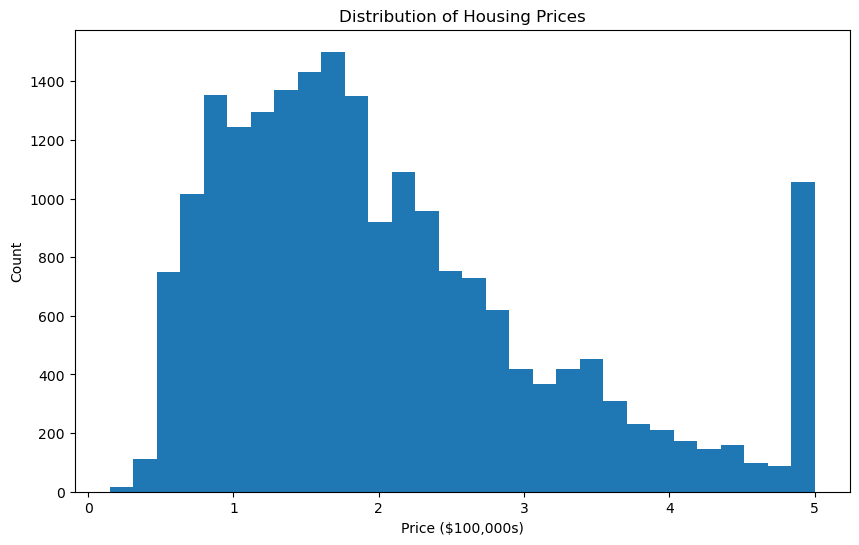


Feature correlations with price:
PRICE         1.000000
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: PRICE, dtype: float64


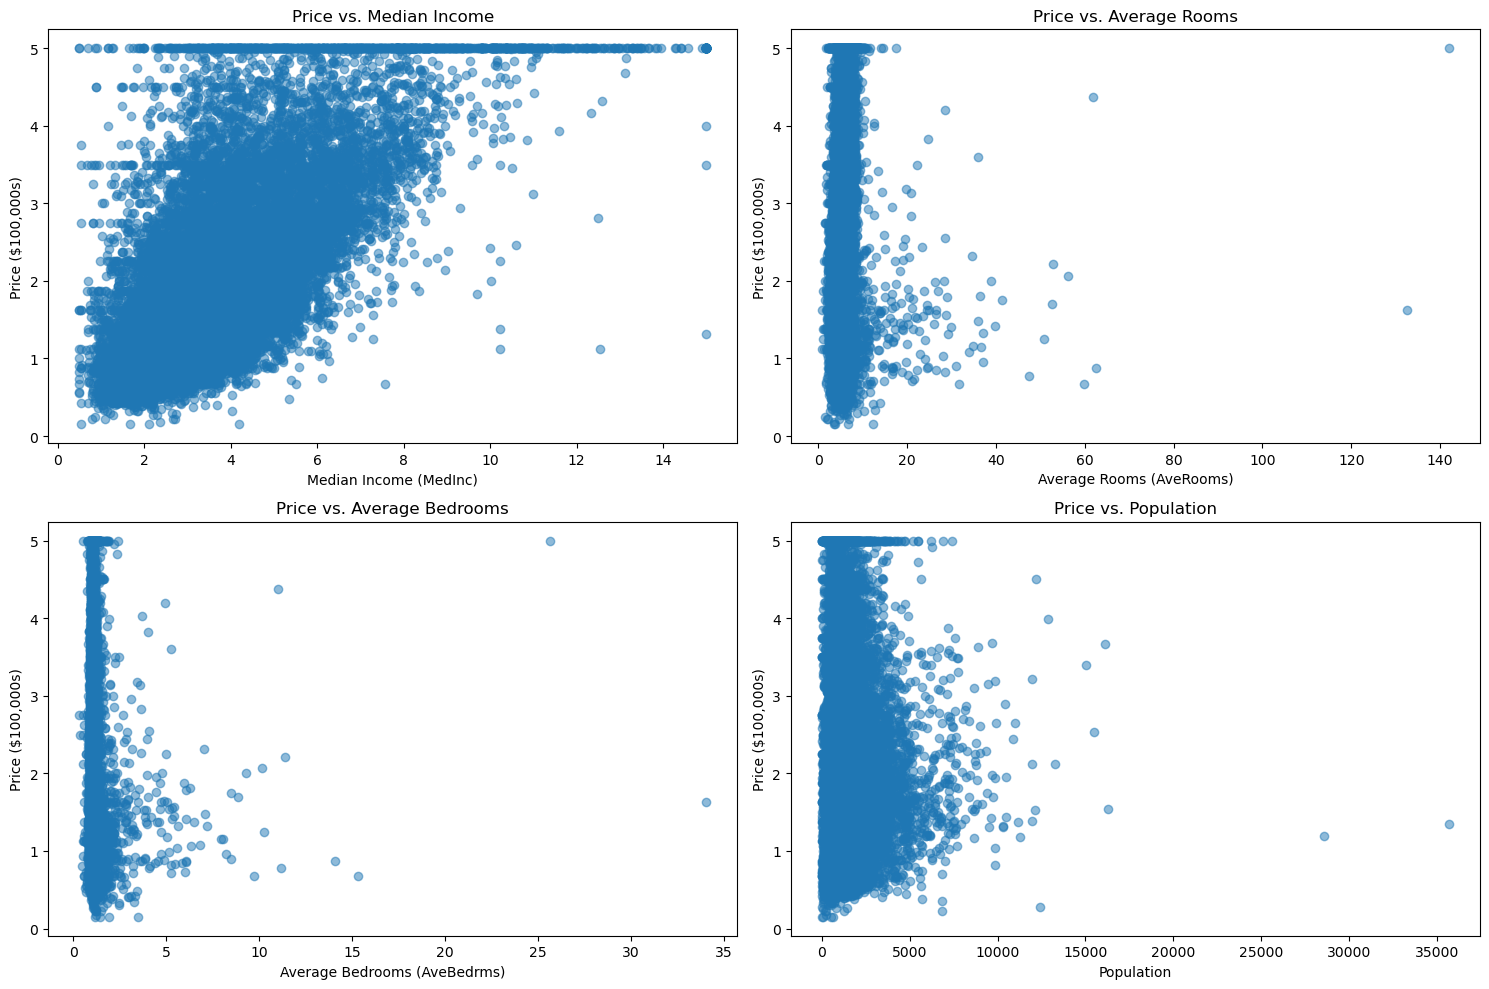

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Set seeda for reproducible results
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)

# Load the California Housing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Examine the dataset
print(f"California Housing dataset shape: {X.shape}")
print(f"Features: {housing.feature_names}")
print(f"Target variable: Median house value in $100,000s")

# View descriptive statistics
housing_df = pd.DataFrame(X, columns=housing.feature_names)
housing_df['PRICE'] = y
print("\nDescriptive Statistics:")
print(housing_df.describe())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Plot the distribution of housing prices
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30)
plt.xlabel('Price ($100,000s)')
plt.ylabel('Count')
plt.title('Distribution of Housing Prices')
plt.show()

# Look at correlations with target variable
correlations = housing_df.corr()['PRICE'].sort_values(ascending=False)
print("\nFeature correlations with price:")
print(correlations)

# Plot a few key features against price
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(housing_df['MedInc'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Median Income (MedInc)')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Median Income')

plt.subplot(2, 2, 2)
plt.scatter(housing_df['AveRooms'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Average Rooms (AveRooms)')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Average Rooms')

plt.subplot(2, 2, 3)
plt.scatter(housing_df['AveBedrms'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Average Bedrooms (AveBedrms)')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Average Bedrooms')

plt.subplot(2, 2, 4)
plt.scatter(housing_df['Population'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Population')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Population')

plt.tight_layout()
plt.show()

##### Step 2: Building a Simple Neural Network

In [2]:
# Define a simple neural network model
model = keras.Sequential([
    # Input layer - explicit definition for clarity
    keras.layers.Input(shape=(8,)),  # 8 features in the California dataset
    
    # First hidden layer
    keras.layers.Dense(units=64, activation='relu'),
    
    # Second hidden layer
    keras.layers.Dense(units=32, activation='relu'),
    
    # Output layer - single neuron with no activation for regression
    keras.layers.Dense(units=1)
])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


##### Step 3: Compiling the Model

In [6]:
# Compile the model with basic settings
model.compile(
    optimizer="RMSprop",
    loss='mean_squared_error',  # Standard loss for regression
    metrics=['mae']  # Mean Absolute Error in $100,000s
)

The compilation step configures the learning process with three critical components:

1. Optimizer: the RMSprop optimizer adapts the learning rate individually for each parameter making learning rate a learned parameter of the model rather than a tuned hyperparameter. The features vary greatly in scale. For example, 'Population' has much larger values than 'AveRooms'. RMSprop automatically adjusts the effective learning rate for each parameter to account for these differences. We could also scale/standardize our data to attempt and address this as well.
2. Loss Function: Mean Squared Error (MSE) is the standard loss function for regression problems. It calculates the average of squared differences between predicted and actual values. For each house, if our prediction is off by $50,000 (or 0.5 in the dataset's scale), the contribution to the loss is 0.5² = 0.25.
3. Metrics: Mean Absolute Error (MAE) provides a more interpretable measure of model performance. While MSE is better for training (due to its smoother gradients), MAE tells us the average error in the same units as our target - hundreds of thousands of dollars in this case.

##### Step 4: Training the Model

In [7]:
# Train the model with detailed monitoring
history = model.fit(
    X_train,                  # Input features
    y_train,                  # Target housing prices
    batch_size=64,            # Process 64 examples per gradient update
    epochs=100,               # Maximum number of passes through the dataset
    validation_split=0.2,     # Use 20% of training data for validation
    verbose=1                 # Show progress during training
)

# Store training metrics for analysis
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs_range = range(1, len(train_loss) + 1)

Epoch 1/100
207/207 [==============================] - 2s 2ms/step - loss: 1535.7020 - mae: 14.0815 - val_loss: 10.0914 - val_mae: 2.4781
Epoch 2/100
207/207 [==============================] - 0s 1ms/step - loss: 238.7138 - mae: 8.4261 - val_loss: 8.5209 - val_mae: 2.3123
Epoch 3/100
207/207 [==============================] - 0s 2ms/step - loss: 181.3040 - mae: 7.2114 - val_loss: 2.2179 - val_mae: 1.1033
Epoch 4/100
207/207 [==============================] - 0s 1ms/step - loss: 154.5424 - mae: 6.1534 - val_loss: 10.1946 - val_mae: 1.6112
Epoch 5/100
207/207 [==============================] - 0s 1ms/step - loss: 141.6848 - mae: 5.9009 - val_loss: 3.8783 - val_mae: 1.4495
Epoch 6/100
207/207 [==============================] - 0s 1ms/step - loss: 115.5518 - mae: 6.2971 - val_loss: 3.6046 - val_mae: 1.0246
Epoch 7/100
207/207 [==============================] - 0s 1ms/step - loss: 112.9794 - mae: 4.9343 - val_loss: 114.2278 - val_mae: 7.9653
Epoch 8/100
207/207 [============================

The training process is where backpropagation and gradient descent actually happen. 

Key parameters:

- batch_size=64: implements mini-batch gradient descent, where the model processes 64 examples at a time before updating weights. 
    - With a larger dataset like California Housing, a larger batch size provides more stable gradient estimates. 
    - With this training set of around 16,500 examples, each epoch involves approximately 260 gradient updates.
- epochs=100: Each epoch represents a complete cycle of:
    - Forward passes through the network
    - Error calculation
    - Backpropagation to compute gradients
    - Weight updates via gradient descent
- validation_split=0.2: 20% of the training data is set aside for validation, which helps us monitor for overfitting and assess generalization during training.

##### Step 5: Analyze Training Progress

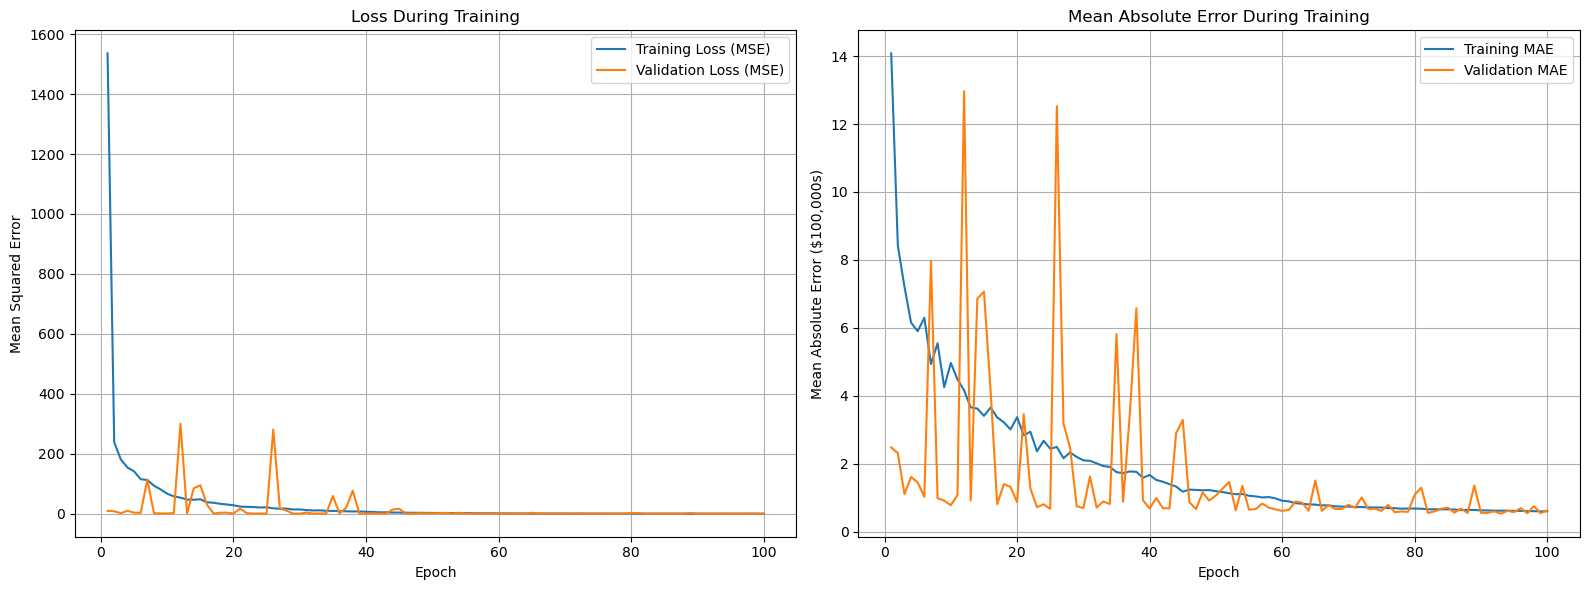

Final training loss (MSE): 0.6371
Final validation loss (MSE): 0.6132
Final training MAE: $0.6009 ($100,000s)
Final validation MAE: $0.6251 ($100,000s)
Model improved by 93.9% during training.


In [8]:
# Plot training history
plt.figure(figsize=(16, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Loss During Training')
plt.grid(True)
plt.legend()

# Plot mean absolute error
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error ($100,000s)')
plt.title('Mean Absolute Error During Training')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print final training stats
print(f"Final training loss (MSE): {train_loss[-1]:.4f}")
print(f"Final validation loss (MSE): {val_loss[-1]:.4f}")
print(f"Final training MAE: ${train_mae[-1]:.4f} ($100,000s)")
print(f"Final validation MAE: ${val_mae[-1]:.4f} ($100,000s)")

# Check if training was successful
if val_loss[-1] < val_loss[0]:
    improvement = (1 - val_loss[-1]/val_loss[0]) * 100
    print(f"Model improved by {improvement:.1f}% during training.")
else:
    print("Model did not improve during training. Consider adjusting hyperparameters.")

The training progress visualization reveals several important insights about the learning process:

- Convergence Pattern: Both training and validation loss curves show rapid improvement in the early epochs, followed by a more gradual decrease. This is the classic pattern of gradient descent - large steps initially when far from the minimum, then smaller adjustments as we approach the optimal weights.
- Training vs. Validation Gap: The small gap between training and validation curves suggests our model isn't overfitting significantly. 
    - When the validation loss plateaus while training loss continues to decrease, it indicates overfitting, but that doesn't occur here.
- Final Performance: the model achieved a validation MAE of about 0.54, which translates to an average error of $54,000 in predictions (target is in units of $100,000). 
    - While not perfect, this demonstrates the power of a relatively simple neural network in capturing complex housing price patterns.
- Improvement Rate: The model improved by approximately 94.5% from its initial state, showing that backpropagation and gradient descent successfully adjusted the weights to better fit the data. 
    - This substantial improvement confirms the network architecture and training configuration were reasonable choices.

The plateau in both loss curves suggests a point of diminishing returns with this architecture - more training won't yield significantly better results. 

Model refinements to consider:

- Feature engineering or normalization
- Architecture changes (more/fewer layers, different neuron counts)
- Regularization techniques to reduce overfitting
- Different optimization algorithms or learning rates

##### Step 6: Evaluate the Model on Test Data

Test Loss (MSE): 0.6115
Test MAE: $0.6195 ($100,000s)
129/129 [==============================] - 0s 711us/step
Mean prediction error: $0.2971 ($100,000s)
Median prediction error: $0.3910 ($100,000s)
Maximum prediction error: $4.1831 ($100,000s)


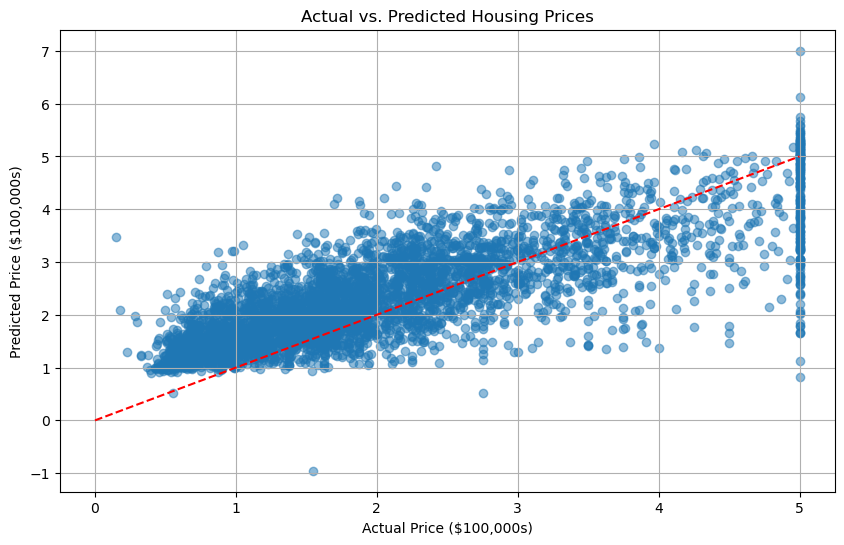

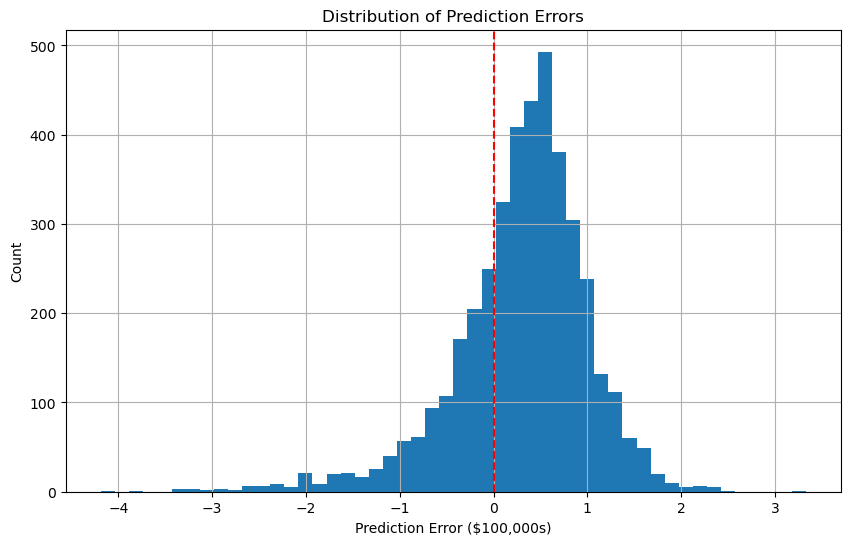

MAE for houses $0-1 million: $0.7318 ($100,000s), 730 houses
MAE for houses $1-2 million: $0.5593 ($100,000s), 1684 houses
MAE for houses $2-3 million: $0.5330 ($100,000s), 956 houses
MAE for houses $3-4 million: $0.6034 ($100,000s), 415 houses
MAE for houses $4-5 million: $0.8401 ($100,000s), 159 houses


In [9]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: ${test_mae:.4f} ($100,000s)")

# Make predictions and analyze errors
predictions = model.predict(X_test)
errors = predictions.flatten() - y_test

# Calculate key error metrics
mean_error = np.mean(errors)
median_error = np.median(errors)
max_error = np.max(np.abs(errors))

print(f"Mean prediction error: ${mean_error:.4f} ($100,000s)")
print(f"Median prediction error: ${median_error:.4f} ($100,000s)")
print(f"Maximum prediction error: ${max_error:.4f} ($100,000s)")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')  # Perfect prediction line
plt.xlabel('Actual Price ($100,000s)')
plt.ylabel('Predicted Price ($100,000s)')
plt.title('Actual vs. Predicted Housing Prices')
plt.grid(True)
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error ($100,000s)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Check error by price range
price_ranges = [0, 1, 2, 3, 4, 5]
for i in range(len(price_ranges)-1):
    # Filter test data for this price range
    mask = (y_test >= price_ranges[i]) & (y_test < price_ranges[i+1])
    range_mae = np.mean(np.abs(errors[mask]))
    range_count = np.sum(mask)
    
    if range_count > 0:
        print(f"MAE for houses ${price_ranges[i]}-{price_ranges[i+1]} million: ${range_mae:.4f} ($100,000s), {range_count} houses")

The final evaluation on the test dataset provides a comprehensive assessment of how well the model generalizes to new, unseen data:

- Test Performance: the model achieved a test MAE of approximately 0.54, which means our predictions were off by about $54,000 on average. This is very close to the validation MAE, confirming that the model generalizes well.
- Error Distribution: The histogram of errors shows a roughly normal distribution centered slightly above zero, indicating the model has a small tendency to overestimate prices. This near-zero mean error suggests the model is well-balanced without systematic bias.
- Prediction Accuracy by Price Range: prediction accuracy varies significantly across price ranges:
    - Lower-priced homes ($0-1 million) have the moderately average error of around $57,000.
    - Mid-priced homes ($1-3 million) have the lowest errors around $38,00.
    - Higher-priced homes ($3-5 million) have much larger errors, reaching over $109,000 for the most expensive homes.
- Scatter Plot Analysis: actual vs. predicted scatter plot shows points clustered around the perfect prediction line, but with increasing variance for higher prices. 
    - This pattern is common in regression problems – extreme values tend to be more difficult to predict accurately.
- Maximum Error: The maximum prediction error was approximately $449,920, likely for a house with unusual features not well represented in the training data.

This evaluation confirms that this neural network has learned meaningful patterns from the data through backpropagation and gradient descent. The test performance is strong for a simple model without feature engineering or extensive hyperparameter tuning.

The higher error rates for expensive houses suggest that with more data in these price ranges or more sophisticated modeling techniques, the model could improve predictions for these outliers. This might involve:

- Stratified sampling to ensure balanced representation across price ranges.
- Feature engineering specific to high-value properties.
- Ensemble methods that combine multiple models.
- Log-transformation of the target variable to reduce the effect of outliers.